### 第一部分是收集并处理数据

### 第二部分是用QQ图 及 kde与正态分布图比较得出并不服从正态分布

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from scipy.stats import norm
import scipy.stats as stats

# 选择10种资产并获取数据
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TLT','SPY','GLD','CL=F','BTC-USD']

# 下载数据
data = yf.download(stocks, start="2015-01-01", end="2025-01-01")

# 检查数据
if data.empty:
    print("No data was downloaded. Please check your stock codes or date range.")
else:
    # 尝试访问 'Adj Close'，如果不存在则使用 'Close'
    if 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    elif 'Close' in data.columns.levels[0]:
        data = data['Close']
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' columns are available in the downloaded data.")
    
    print(data.head())

# 计算每日对数收益率
returns = np.log(data / data.shift(1)).dropna()

# 保存收益率数据到CSV文件
returns.to_csv("stock_returns.csv")

# 使用PCA分解收益率
pca = PCA()
pca.fit(returns)

# 提取系统性风险因子
sys_risk = returns @ pca.components_[0]  # 第一个主成分作为系统性风险因子
# 确保 sys_risk 和 returns 是 NumPy 数组
sys_risk = np.array(sys_risk)  # 转为 NumPy 数组
returns_array = returns.values  # 提取返回值

# 使用 NumPy 操作避免多维索引问题
sys_risk_expanded = np.expand_dims(sys_risk, axis=1)
sys_risk_df = pd.DataFrame(sys_risk, index=returns.index, columns=['Systematic Risk'])
sys_risk_df.to_csv("systematic_risk.csv")

idio_risk = returns_array - sys_risk_expanded @ pca.components_[:1]
idio_risk_df = pd.DataFrame(idio_risk, index=returns.index, columns=returns.columns)
idio_risk_df.to_csv("idiosyncratic_risk.csv")

# 确保 sys_risk 和 idio_risk 是 NumPy 数组
sys_risk = np.array(sys_risk).flatten()  # 展平成一维数组
idio_risk = np.array(idio_risk)  # 确保是 NumPy 数组

# 计算 KDE
kde1 = gaussian_kde(sys_risk)
kde2 = gaussian_kde(idio_risk.T)
# 从 KDE 中随机取样
Nsims = 6000
simulated_sys_risk = kde1.resample(Nsims).flatten()
simulated_idio_risk = kde2.resample(Nsims) .T

final_simulated_returns = simulated_sys_risk[:, np.newaxis] + simulated_idio_risk

# 将最终的模拟收益率转换为 DataFrame 并保存到csv文件
final_simulated_returns_df = pd.DataFrame(final_simulated_returns, columns=returns.columns)

final_simulated_returns_df.to_csv("final_simulated_returns.csv", index=False)

# 将时间维度插入到S中以保持一致性
S = np.expand_dims(final_simulated_returns, axis=0)




[*********************100%***********************]  10 of 10 completed
d:\Anaconda\envs\torch\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Ticker           AAPL     AMZN     BTC-USD       CL=F         GLD      GOOGL  \
Date                                                                           
2015-01-01        NaN      NaN  314.248993        NaN         NaN        NaN   
2015-01-02  24.347170  15.4260  315.032013  52.689999  114.080002  26.381865   
2015-01-03        NaN      NaN  281.082001        NaN         NaN        NaN   
2015-01-04        NaN      NaN  264.195007        NaN         NaN        NaN   
2015-01-05  23.661276  15.1095  274.473999  50.040001  115.800003  25.879185   

Ticker           MSFT      NVDA         SPY         TLT  
Date                                                     
2015-01-01        NaN       NaN         NaN         NaN  
2015-01-02  40.152485  0.483144  172.592834   98.977821  
2015-01-03        NaN       NaN         NaN         NaN  
2015-01-04        NaN       NaN         NaN         NaN  
2015-01-05  39.783234  0.474983  169.475937  100.532570  


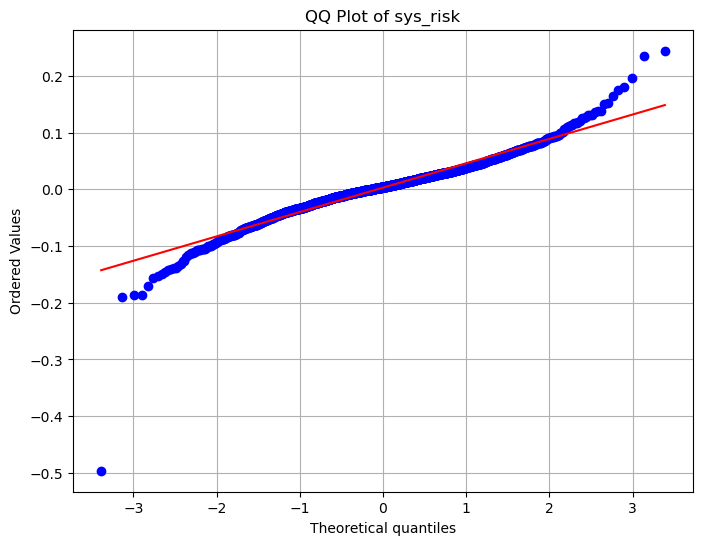

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats

# 创建 QQ 图
plt.figure(figsize=(8, 6))
stats.probplot(sys_risk, dist="norm", plot=plt)
plt.title('QQ Plot of sys_risk')
plt.grid()
plt.show()



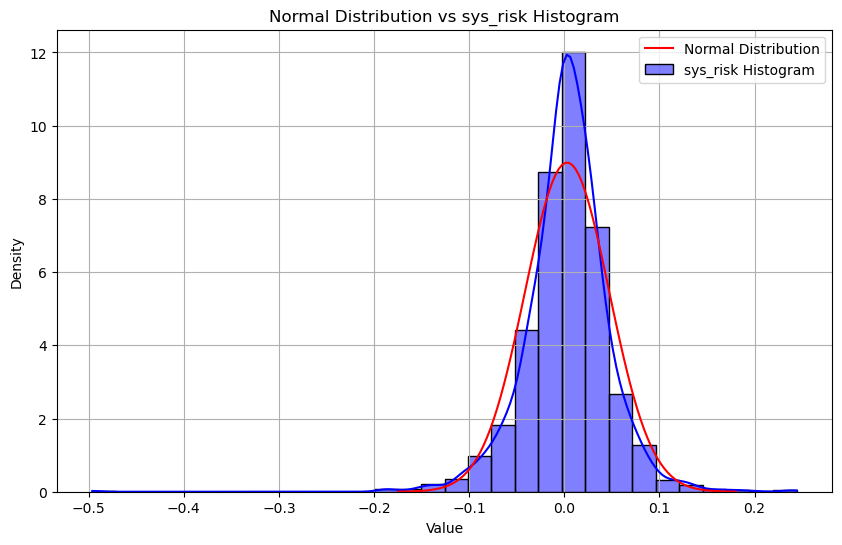

In [3]:
mean_sys_risk = np.mean(sys_risk)
var_sys_risk = np.var(sys_risk)

plt.figure(figsize=(10, 6))

# 绘制 sys_risk 的直方图
sns.histplot(sys_risk, bins=30, kde=True, stat="density", color='blue', label='sys_risk Histogram')

# 绘制正态分布曲线
x = np.linspace(mean_sys_risk - 4 * np.sqrt(var_sys_risk), mean_sys_risk + 4 * np.sqrt(var_sys_risk), 100)
plt.plot(x, norm.pdf(x, mean_sys_risk, np.sqrt(var_sys_risk)), color='red', label='Normal Distribution')

# 添加图例和标题
plt.title('Normal Distribution vs sys_risk Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()